# Aug 28, 2025: group align estimates per animal

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
from numba import jit
# import arviz as az
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [6]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f9e9c3501f0>

In [7]:
# indiv level estimates
indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes/{SBM}_desc-df.pkl'))
indests_df = []
for indiv_file in tqdm(indiv_files):
    with open(indiv_file, 'rb') as f:
        df = pickle.load(f)
    # sub = [s for s in indiv_file.split('/') if 'sub-' in s][0].split('-')[-1]
    # df['sub'] = [sub] * len(df)
    # df['sbm'] = [SBM] * len(df)
    indests_df += [df]
indests_df = pd.concat(indests_df).reset_index(drop=True)
indests_df

100%|██████████| 9/9 [28:23<00:00, 189.26s/it]


,sub,sbm,mode_id,mode,pi,omega,sigma
0,SLC01,sbm-nd-h,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.177295,0.050187
1,SLC01,sbm-nd-h,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.132086,0.051405
2,SLC01,sbm-nd-h,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.122464,0.058948
3,SLC01,sbm-nd-h,3,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.093199,0.055705
4,SLC01,sbm-nd-h,4,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.091858,0.081788
...,...,...,...,...,...,...,...
69,SLC10,sbm-nd-h,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 9.991008092716555e-05, 0...",0.200220,0.038061
70,SLC10,sbm-nd-h,3,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0017115960633290544, 0...",0.140248,0.037859
71,SLC10,sbm-nd-h,4,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.061952,0.052215
72,SLC10,sbm-nd-h,5,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0007012622720897616, 0...",0.028526,0.039699


In [8]:
mode = indests_df.iloc[0]['mode']
bs = list(mode.get_nested_partitions().values())
bs[0]

[array([10,  0, 13,  0, 13, 13,  0,  0,  2,  0, 13,  0,  0, 13, 13,  4,  4,
         4,  2,  4,  4,  4,  2,  2,  4,  2,  4, 18,  3, 10,  3, 18, 10, 10,
        12, 11, 11,  2,  2, 19,  4, 15, 15, 16, 16, 11, 16,  3, 11,  5,  5,
         5, 15, 15, 15, 21, 11, 12, 15,  5,  5,  0, 11,  3,  5,  0,  5,  5,
         3, 17, 17,  5,  9,  5,  5, 19, 14, 20, 20, 20, 20, 14, 14, 14, 14,
        17, 16,  0, 13,  0, 12, 12,  0,  0, 12, 12,  0, 21,  1, 12,  6,  6,
         4,  6,  2,  6,  6,  7,  6,  2,  6,  6, 19, 18,  3, 10,  3, 10, 10,
        18, 21,  1,  1,  2,  2, 19,  1,  1,  1, 16, 10,  8, 16,  3,  8,  8,
         8,  8,  1,  7,  1,  1,  1,  1,  1,  8,  1, 21,  9,  3,  8,  0,  9,
         9,  3, 17, 17,  9,  9,  9,  9,  7,  7, 14, 22, 22, 22,  7,  7, 14,
         7,  7]),
 array([1, 5, 1, 0, 1, 4, 6, 2, 5, 4, 0, 4, 6, 1, 3, 3, 0, 6, 0, 2, 3, 0,
        2]),
 array([0, 0, 0, 0, 0, 0, 0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0])]

<Axes: xlabel='sub', ylabel='mode_id'>

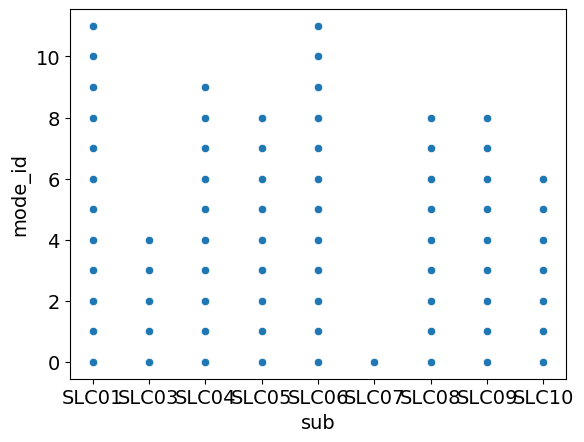

In [9]:
sns.scatterplot(indests_df, x='sub', y='mode_id')

In [10]:
# CHECK IF MODES PER ANIMAL ARE ALIGNED, 
# THEN WE CAN ALIGN THEM AT THE GROUP LEVEL

In [11]:
def get_membership_matrix(args, df, col='pi'):
    num_modes = len(df)
    num_comms = np.max(df[col].apply(lambda pi: pi.shape[-1]))
    num_rois = df.iloc[0][col].shape[0]
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode in range(num_modes):
        pi = df.iloc[idx_mode][col]
        M[:, idx_mode, :pi.shape[-1]] = pi
    return M

In [12]:
soft_df = []
for sub, group in indests_df.groupby('sub'):
    M = get_membership_matrix(args, group)
    omegas = group['omega'].to_list()
    X = np.average(M, axis=1, weights=omegas)
    soft_df += [pd.DataFrame(dict(
        sub=[sub],
        soft_comm=[X],
    ))]
soft_df = pd.concat(soft_df).reset_index(drop=True)
soft_df

,sub,soft_comm
0,SLC01,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,SLC03,"[[0.9991998399679936, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,SLC04,"[[0.0, 0.0, 0.0, 0.9999800119928043, 0.0, 0.0,..."
3,SLC05,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,SLC06,"[[0.0, 0.0, 0.99994, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,SLC07,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000779844031..."
6,SLC08,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.000400080016..."
7,SLC09,"[[0.0, 0.0, 0.0, 0.00011995201919232307, 0.0, ..."
8,SLC10,"[[0.0, 0.0, 0.0, 0.0, 0.0003600720144028805, 0..."


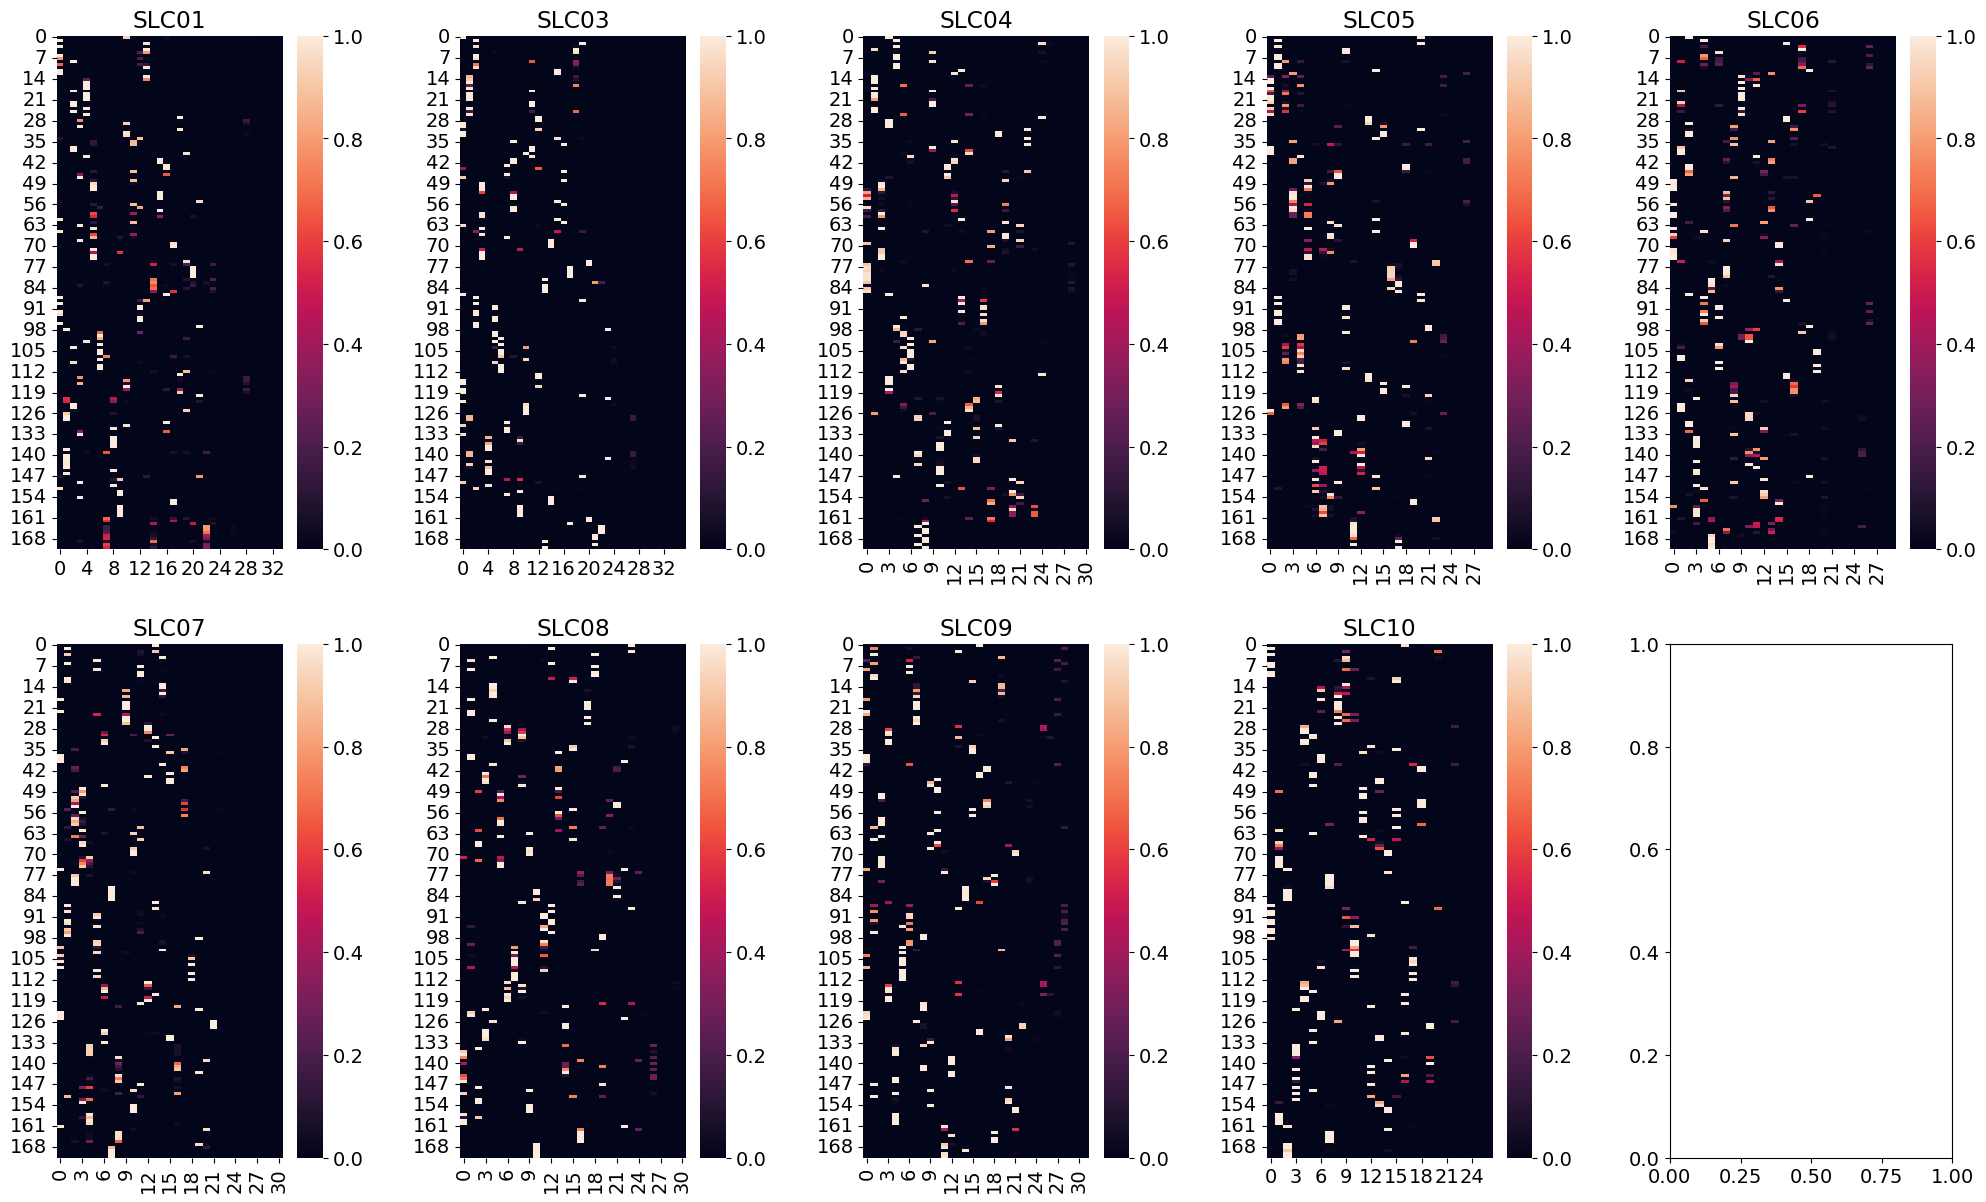

In [13]:
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, row in soft_df.iterrows():
    r, c = idx // ncols, idx % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    sns.heatmap(row['soft_comm'], ax=ax)
    ax.set(title=f'{row["sub"]}')

In [14]:
# YES, MODES PER ANIMAL ALIGN WELL.
# WE CAN SEE THIS THROUGH THE SHAPRNESS OF SOFT_COMMS: sharp soft_comms means all modes align well, hence they average to 1. 

In [15]:
# GROUP ALIGN

---
sample partitions from each mode, align them, recompute marginals: stochastic solution

In [16]:
def sample_partitions(args, indests_df):
    all_bs_df = []
    for idx, row in tqdm(indests_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_partitions().values()), 
            row['num_samples']
        )
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

def sample_nested_partitions(args, indests_df):
    all_bs_df = []
    for idx, row in tqdm(indests_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_nested_partitions().values()), 
            row['num_samples']
        )
        bs = [gt.nested_partition_clear_null(b) for b in bs]
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

In [17]:
# sample partitions per mode
args.total_samples = 1000
indests_df['num_samples'] = indests_df['omega'].apply(lambda x: np.round(x * args.total_samples).astype(int) if x > 0.01 else 1)
if args.sbm in ['m', 'a', 'd']:
    all_bs_df = sample_partitions(args, indests_df)
if args.sbm in ['h']:
    all_bs_df = sample_nested_partitions(args, indests_df)

74it [00:38,  1.90it/s]


In [18]:
# align all samples iteratively until the labels converge
pmode = gt.PartitionModeState(all_bs_df['b'], relabel=True, nested=args.nested, converge=False)
ent_diff = -np.inf
while ent_diff < 1e-10:
    ed = pmode.replace_partitions()
    print(ed)
    if np.isclose(ed, ent_diff, rtol=1e-10):
        break
    ent_diff = ed

-37476.25685431729
-7855.4661095963165
-1361.3055193583243
-2578.474280785066
-333.38259495304834
-1037.2399754504277
-1.9804638747664285
-0.13403919396660058
-8.253846317529678e-08
-8.253846317529678e-08


In [19]:
if args.sbm in ['m', 'a', 'd']:
    bs = pmode.get_partitions()
if args.sbm in ['h']:
    bs = pmode.get_nested_partitions()
bs = {k:v for k, v in sorted(bs.items())}
# bs = {k:v for k, v in (bs.items())}
all_bs_df['b_aligned'] = list(bs.values())

In [20]:
all_bs_df

,mode_id,b,b_aligned
0,0,"[[10, 0, 13, 0, 13, 13, 0, 12, 2, 12, 13, 0, 0...","[[0, 1, 2, 1, 2, 2, 1, 3, 4, 3, 2, 1, 1, 2, 2,..."
1,0,"[[10, 0, 13, 0, 13, 12, 0, 0, 2, 0, 13, 0, 0, ...","[[0, 1, 2, 1, 2, 3, 1, 1, 4, 1, 2, 1, 1, 2, 2,..."
2,0,"[[10, 0, 13, 0, 13, 13, 0, 0, 2, 0, 13, 0, 0, ...","[[0, 1, 2, 1, 2, 2, 1, 1, 4, 1, 2, 1, 1, 2, 2,..."
3,0,"[[10, 0, 13, 0, 13, 13, 0, 0, 2, 0, 13, 0, 0, ...","[[0, 1, 2, 1, 2, 2, 1, 1, 4, 1, 2, 1, 1, 2, 2,..."
4,0,"[[10, 0, 13, 0, 13, 13, 0, 0, 2, 0, 13, 0, 0, ...","[[0, 1, 2, 1, 2, 2, 1, 1, 4, 1, 2, 1, 1, 2, 2,..."
...,...,...,...
9001,72,"[[16, 0, 9, 0, 9, 9, 0, 0, 10, 0, 0, 12, 15, 9...","[[11, 1, 2, 1, 2, 2, 1, 1, 3, 1, 1, 37, 27, 2,..."
9002,72,"[[16, 0, 9, 0, 9, 8, 0, 0, 10, 0, 0, 15, 15, 9...","[[11, 1, 2, 1, 2, 5, 1, 1, 3, 1, 1, 27, 27, 2,..."
9003,72,"[[16, 0, 9, 0, 9, 9, 0, 0, 10, 0, 0, 15, 15, 9...","[[11, 1, 2, 1, 2, 2, 1, 1, 3, 1, 1, 27, 27, 2,..."
9004,72,"[[16, 0, 9, 0, 9, 9, 0, 0, 10, 0, 0, 15, 15, 9...","[[11, 1, 2, 1, 2, 2, 1, 1, 3, 1, 1, 27, 27, 2,..."


In [21]:
def get_pi_matrix(args, mrgnls):
    num_comms = np.max([len(mrgnl) for mrgnl in mrgnls])
    pi = np.zeros((len(mrgnls), num_comms))

    for idx_node, mrgnl in enumerate(mrgnls):
        mrgnl = np.array(mrgnl)
        pi[idx_node, np.where(mrgnl)[0]] = mrgnl[mrgnl > 0]

    pi = pi / np.expand_dims(pi.sum(axis=-1), axis=-1)
    return np.round(pi, decimals=3) # marginals matrix

In [22]:
if args.sbm in ['m', 'a', 'd']:
    pis_df = []
    for key, group in tqdm(all_bs_df.groupby(by='mode_id')):
        pm = gt.PartitionModeState(bs=group['b_aligned'], relabel=False, nested=args.nested, converge=False)
        mrgnls = pm.get_marginal(g)
        pi = get_pi_matrix(args, mrgnls)
        df = pd.DataFrame(dict(
            mode_id=[key],
            mode=[pm],
            pi=[pi],
        ))
        pis_df += [df]
        # break
    pis_df = pd.concat(pis_df).reset_index(drop=True)

In [23]:
def get_M(b):
    b = np.array(b).reshape(-1, 1)
    categories = np.arange(-1, np.max(b)+1).tolist() # first one indicating absence of comm. in the partition
    enc = OneHotEncoder(sparse_output=False, categories=[categories])
    M = enc.fit_transform(b)
    return M

def get_marginals(bs, level=0):
    all_Ms = []
    for bs_ in (bs):
        b = bs_[level]
        M = get_M(b)
        all_Ms.append(M)

    shapes = np.stack(list(zip(*[M.shape for M in all_Ms])), axis=-1)
    num_nodes, num_comms = np.max(shapes, axis=0)
    num_samples = len(all_Ms)

    Ms = np.zeros((num_nodes, num_comms, num_samples))
    for idx, M in enumerate(all_Ms):
        Ms[:M.shape[0], :M.shape[1], idx] = M

    rescale = lambda M: M / M.sum(axis=1, keepdims=True)

    M = np.mean(Ms, axis=-1) # frequencies
    M = M[:, 1:] # remove the absence indicating column
    M = rescale(M) # renormalize marginals to ensure we compute marginal whenever node is present in the partition
    M = np.nan_to_num(M)
    return M

def get_nested_marginals(bs, levels=[0, 1, 2]):
    Ms = []
    for level in levels:
        M = get_marginals(bs, level)
        Ms.append(M)
    return Ms

def project_level(Ms, level):
    # project level `level` onto level 0
    M_ = Ms[0]
    for l in range(1, level+1):
        M_ = M_ @ Ms[l]
    return M_

In [24]:
if args.sbm in ['h']:
    pis_df = []
    for key, group in tqdm(all_bs_df.groupby(by='mode_id')):
        pm = gt.PartitionModeState(
            bs=group['b_aligned'], 
            relabel=False, 
            nested=args.nested, 
            converge=False,
        )
        bs = list(pm.get_nested_partitions().values())
        
        levels=np.arange(np.max([len(bs_) for bs_ in bs]))
        Ms_ = get_nested_marginals(bs, levels)
        Ms = [project_level(Ms_, level) for level in levels]

        dct = {f'mode_id':[key]}
        dct[f'mode'] = [pm]
        for level, M in enumerate(Ms):
            dct[f'pi_{level}'] = [M]
        df = pd.DataFrame(dct)
        pis_df += [df]
        # break
    pis_df = pd.concat(pis_df).reset_index(drop=True)

  0%|          | 0/74 [00:00<?, ?it/s]

100%|██████████| 74/74 [01:57<00:00,  1.58s/it]


In [25]:
# indests_df.merge(pis_df, on='mode_id', how='inner', suffixes=['', '_aligned'])
indests_df = pd.concat([indests_df, pis_df.add_suffix('_aligned')], axis=1)
indests_df

,sub,sbm,mode_id,mode,pi,omega,sigma,num_samples,mode_id_aligned,mode_aligned,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,SLC01,sbm-nd-h,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.177295,0.050187,177,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.9887005649717514, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9359379488652687, 0.005585878898145489, 0....","[[0.930047423159928, 0.0689598675440289, 0.000...","[[0.9834189123072902, 0.016581087692710064], [...","[[0.9986182426922744, 0.0013817573077258387], ...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [..."
1,SLC01,sbm-nd-h,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.132086,0.051405,132,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.9924242424242424, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9310146923783288, 0.030073461891643713, 0....","[[0.9138235946904278, 0.08582466128530745, 0.0...","[[0.9869962634416201, 0.013003736558379917], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999..."
2,SLC01,sbm-nd-h,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.122464,0.058948,122,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.9918032786885246, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9911314162859447, 0.0, 0.0083310937919914,...","[[0.942153748551641, 0.049652834378207875, 0.0...","[[0.9897684668039898, 0.0102315331960104], [0....","[[0.9979536933607981, 0.0020463066392020796], ...","[[1.0000000000000002], [1.0], [1.0], [1.0], [1...","[[1.0000000000000002], [1.0], [1.0], [1.0], [1...","[[1.0000000000000002], [1.0], [1.0], [1.0], [1...","[[1.0000000000000002], [1.0], [1.0], [1.0], [1..."
3,SLC01,sbm-nd-h,3,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.093199,0.055705,93,3,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.978494623655914, 0.0, 0.021505376344086023...","[[0.9556018036767258, 0.03341426754538097, 0.0...","[[0.9886639548450163, 0.01133604515498376], [0...","[[0.9981106591408362, 0.0018893408591639602], ...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [..."
4,SLC01,sbm-nd-h,4,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.091858,0.081788,92,4,<graph_tool.inference.partition_modes.Partitio...,"[[0.4782608695652174, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9153526246909989, 0.011887450923367746, 0....","[[0.8920970026110978, 0.09795351233791275, 0.0...","[[0.9745841708956559, 0.025415829104343764], [...","[[0.9999999999999997], [0.9999999999999999], [...","[[0.9999999999999997], [0.9999999999999999], [...","[[0.9999999999999997], [0.9999999999999999], [...","[[0.9999999999999997], [0.9999999999999999], [...","[[0.9999999999999997], [0.9999999999999999], [..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,SLC10,sbm-nd-h,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 9.991008092716555e-05, 0...",0.200220,0.038061,200,69,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.03, 0.0, 0.965, 0.004775, 0.0, 0.0, 0.0, 0...","[[0.9599766855670102, 0.034953587628865974, 9....","[[0.9916111389690722, 0.008388861030927834], [...","[[1.0]

In [26]:
if args.sbm in ['m', 'a', 'd']:
    soft_aligned_df = []
    for sub, group in indests_df.groupby('sub'):
        M = get_membership_matrix(args, group, col=f'pi_aligned')
        omegas = group['omega'].to_list()
        X = np.average(M, axis=1, weights=omegas)
        soft_aligned_df += [pd.DataFrame(dict(
            sub=[sub],
            soft_comm=[X],
        ))]
    soft_aligned_df = pd.concat(soft_aligned_df).reset_index(drop=True)
    display(soft_aligned_df)

if args.sbm in ['h']:
    level = 0
    soft_aligned_df = []
    for sub, group in indests_df.groupby('sub'):
        M = get_membership_matrix(args, group, col=f'pi_{level}_aligned')
        omegas = group['omega'].to_list()
        X = np.average(M, axis=1, weights=omegas)
        soft_aligned_df += [pd.DataFrame(dict(
            sub=[sub],
            soft_comm=[X],
        ))]
    soft_aligned_df = pd.concat(soft_aligned_df).reset_index(drop=True)
    display(soft_aligned_df)

,sub,soft_comm
0,SLC01,"[[0.87504399147758, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
1,SLC03,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,SLC04,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,SLC05,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,SLC06,"[[0.014021303171773759, 0.0, 0.0, 0.0, 0.0, 0...."
5,SLC07,"[[0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
6,SLC08,"[[0.007972009570269728, 0.0, 0.0, 0.0, 0.0, 0...."
7,SLC09,"[[0.0019971809256095546, 0.0, 0.0, 0.0, 0.0, 0..."
8,SLC10,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001001771782..."


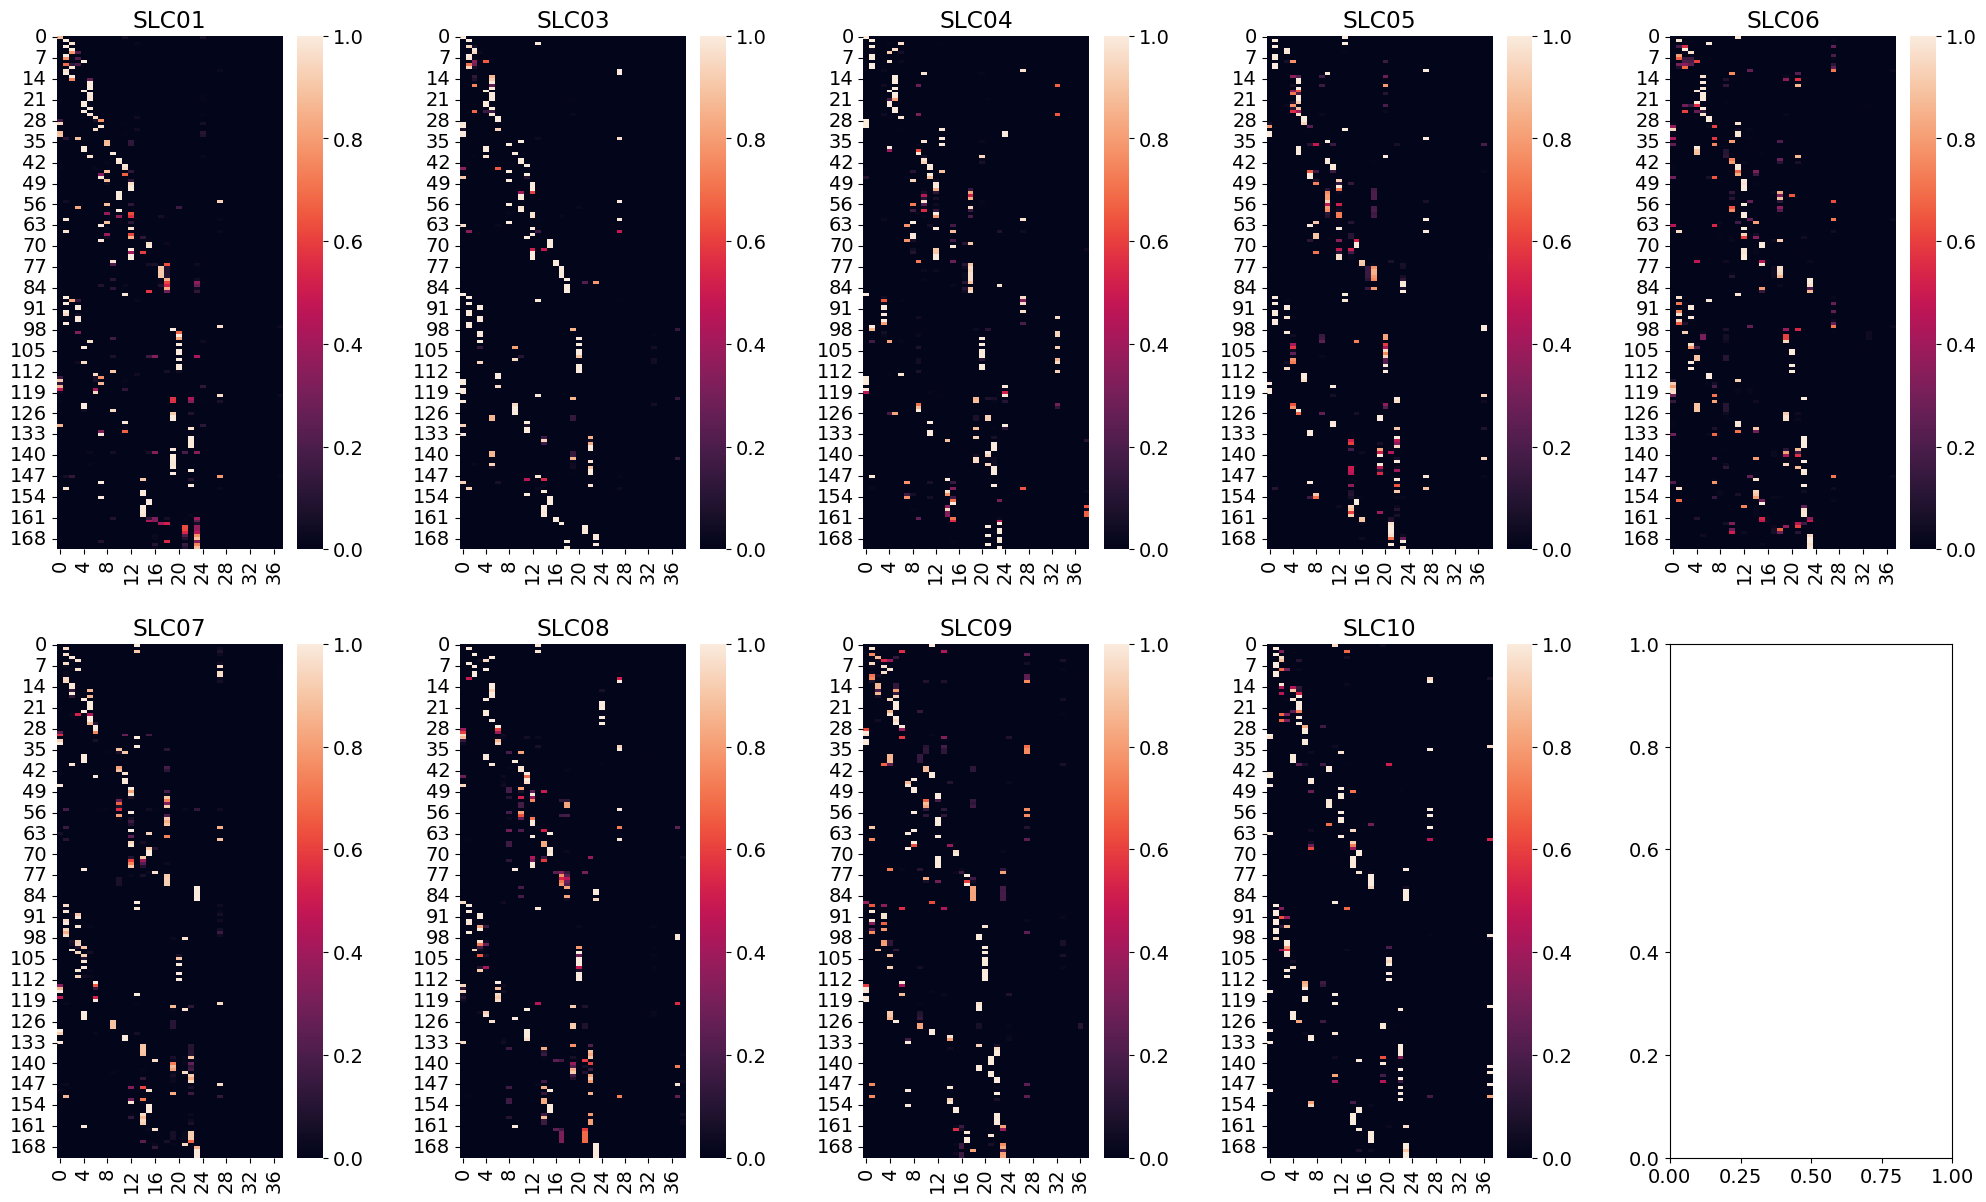

In [27]:
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
# X = soft_aligned_df.iloc[0]['soft_comm']
for idx, row in soft_aligned_df.iterrows():
    r, c = idx // ncols, idx % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    sns.heatmap(row['soft_comm'], ax=ax)
    ax.set(title=f'{row["sub"]}')

[Text(0.5, 1.0, 'group'),
 Text(0.5, 31.722222222222207, 'comm'),
 Text(15.72222222222222, 0.5, 'roi')]

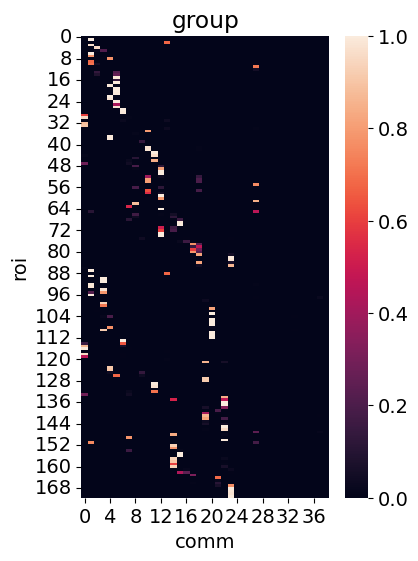

In [28]:
SCsA = get_membership_matrix(args, soft_aligned_df, col='soft_comm') # soft comms aligned
# group_soft_comm = np.mean(SCsA, axis=1)
group_soft_comm = np.median(SCsA, axis=1) # robust to outliers

fig, axs = plt.subplots(1, 1, figsize=(4, 6))
ax = axs
sns.heatmap(group_soft_comm, ax=ax)
ax.set(title=f'group', xlabel=f'comm', ylabel=f'roi')

---

In [29]:
# SAVE THE ALIGNED MODES AND MARGINALS

In [30]:
if args.sbm in ['m', 'a', 'd']:
    for sub, group in indests_df.groupby('sub'):
        out_folder = f'{ESTIM_path}/individual/sub-{sub}/partition-modes-group-aligned/{SBM}'
        os.system(f'mkdir -p {out_folder}')

        cols = ['sub', 'sbm', 'mode_aligned', 'omega']
        with open(f'{out_folder}/desc-modes.pkl', 'wb') as f:
            pickle.dump(group[cols], f)
        
        with open(f'{out_folder}/desc-mem-mats.pkl', 'wb') as f:
            pickle.dump(group[['sub', 'sbm', 'pi_aligned', 'omega']], f)
        
        # break

In [31]:
if args.sbm in ['h']:
    for sub, group in indests_df.groupby('sub'):
        out_folder = f'{ESTIM_path}/individual/sub-{sub}/partition-modes-group-aligned/{SBM}'
        os.system(f'mkdir -p {out_folder}')

        cols = ['sub', 'sbm'] +[col for col in list(group.columns) if 'mode_' in col if 'mode_id' not in col] + ['omega']
        with open(f'{out_folder}/desc-modes.pkl', 'wb') as f:
            pickle.dump(group[cols], f)

        cols = ['sub', 'sbm'] +[col for col in list(group.columns) if 'pi_' in col if 'mode_id' not in col] + ['omega']
        with open(f'{out_folder}/desc-mem-mats.pkl', 'wb') as f:
            pickle.dump(group[cols], f)

        # break

---
align the membership matrices using Hungarian algorithm: deterministic solution

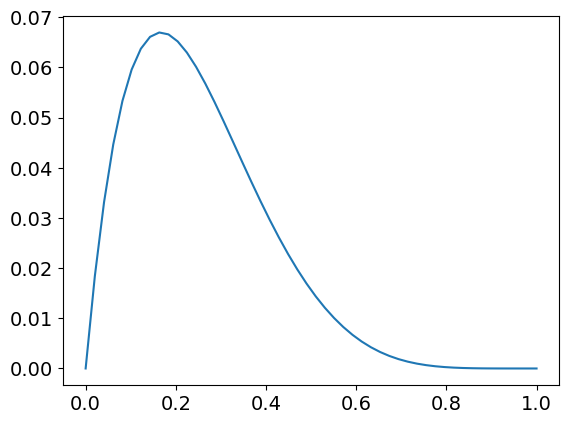

In [32]:
import numpy as np
import matplotlib.pyplot as plt
p = np.linspace(0, 1, 50)
y = (1-p)**5 * p
np.stack([p, y], axis=-1)

plt.plot(p, y)